In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.express as px
import plotly.graph_objects as go
from neuralprophet import NeuralProphet
import warnings


In [136]:
df=pd.read_csv("series.csv")

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CATEGORY    2686 non-null   object
 1   DATE        2686 non-null   object
 2   UNITS_SOLD  2686 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 63.1+ KB


In [140]:
df.head()

,CATEGORY,DATE,UNITS_SOLD
0,CATEG-1,2021-08-17,59
1,CATEG-1,2020-09-19,40
2,CATEG-2,2021-10-26,23
3,CATEG-1,2021-04-27,60
4,CATEG-2,2021-05-05,61


## <u>Análisis visual de las series de tiempo</u>

<Figure size 1200x600 with 0 Axes>

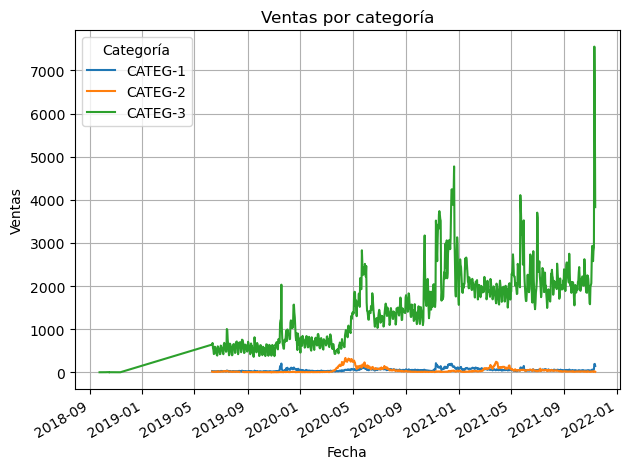

In [142]:

# Make sure dt is datetime
df['dt'] = pd.to_datetime(df['DATE'])
df=df.drop("DATE",axis=1)
# Optional: sort by date
df = df.sort_values(by='dt')

# Pivot the data: rows = dates, columns = categories, values = sales
pivot_df = df.pivot_table(index='dt', columns='CATEGORY', values='UNITS_SOLD', aggfunc='sum')

# Plot
plt.figure(figsize=(12, 6))
pivot_df.plot()
plt.title('Ventas por categoría')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend(title='Categoría')
plt.grid(True)
plt.tight_layout()
plt.show()


#### En base al gráfico podemos ver que la categoria 3 tiene una escala mucho mayor a las otras dos. Para ver cuánto más, analizaremos las estadísticas descriptivas de cada categoría

In [6]:
# Assuming your DataFrame is called df
summary_stats = df.groupby('CATEGORY')['UNITS_SOLD'].describe()
print(summary_stats)


          count         mean         std  min    25%     50%     75%     max
CATEGORY                                                                    
CATEG-1   887.0    53.130778   31.921476  1.0   31.0    47.0    65.0   210.0
CATEG-2   879.0    44.747440   59.467396  1.0    9.0    19.0    51.5   332.0
CATEG-3   920.0  1457.304348  869.635335  0.0  675.0  1452.0  2015.0  7551.0


In [188]:
#Coeficientes de variacion
summary_stats["std"]/summary_stats["mean"]

CATEGORY
CATEG-1    0.600809
CATEG-2    1.328956
CATEG-3    0.596742
dtype: float64

In [233]:


#Iterar para cada categoría y generar el gráfico correspondiente
for cat in df["CATEGORY"].sort_values().unique():
    subset = df[df["CATEGORY"] == cat].sort_values("dt")
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=subset["dt"], 
                             y=subset["UNITS_SOLD"], 
                             mode='lines', 
                             name=cat))
    
    fig.update_layout(
        title=f"Ventas {cat}",
        xaxis_title="Fecha",
        yaxis_title="Unidades Vendidas",
        xaxis_rangeslider_visible=False,  
        showlegend=True,
        width=800,  
        height=600,
    )
    fig.show()


KeyError: 'CATEGORY'

#### Podemos ver que al principio de las series (antes de 2019-06-11) hay unos pocos datos que se encuentran muy alejados del resto de la serie, estos valores son pocos (por lo tanto no agregarían datos relevantes al modelo) y generan un hueco temporal en la serie lo que complica el entrenamiento de modelos temporales. Debido a esto los removeremos, para esto vamos a sacar todos aquellos datos que se encuentren antes de una brecha temporal de al menos 15 dias. 

In [153]:
df = df.sort_values(by=['CATEGORY', 'dt'])
categories=df["CATEGORY"].unique()
gap_length=15
filtered_dfs = []
for i in categories:
    df_cat=df[df.CATEGORY==i]
    df_cat = df_cat.sort_values(by="dt")
    df_cat = df_cat.reset_index(drop=True) 
    df_cat['lag_1'] = df_cat['dt'].shift(1)
    df_cat["diff"]=df_cat["dt"]-df_cat["lag_1"]
    df_cat["diff"]=df_cat['diff'].dt.days
    index = df_cat[df_cat['diff'] > gap_length].index.max()
    
    df_cat = df_cat.loc[index:]  
    filtered_dfs.append(df_cat)
    
df_combined = pd.concat(filtered_dfs, ignore_index=True)
df_combined=df_combined.drop(["diff","lag_1"],axis=1)


#### Verificamos cuales son las fechas de inicio y final de la serie temporal de cada categoría

In [155]:
min_max_fechas = df_combined.groupby('CATEGORY')['dt'].agg(['min', 'max']).reset_index()
min_max_fechas

,CATEGORY,min,max
0,CATEG-1,2019-06-11,2021-11-12
1,CATEG-2,2019-06-11,2021-11-12
2,CATEG-3,2019-06-11,2021-11-12


#### Todas las series tienen un mismo marco temporal, lo que ayudará al momento de generar el modelo

#### El modelo que utilizaremos es NeuralProphet, un modelo que permite incorporar varios tipos de estacionalidad que interesan siendo que tenemos datos diarios de ventas por lo que podemos suponer que hay estacionalidad semanal y anual. Este modelo utiliza la librería Pytorch de deep learning y la utiliza para estimar los componentes estacionales y autoregresivos con redes neuronales. Además permite agregar los feriados nacionales al modelo y permite crear un modelo global con componentes específicos a cada categoría. A continuación modificamos el dataset para ajustarlo al formato requerido por NeuralProphet

In [157]:
# Renombrar las columnas como requiere el modelo
df = df_combined.rename(columns={"dt": "ds", "UNITS_SOLD": "y","CATEGORY":"ID"})

# Convertir la variable ds para asegurarnos de que sea del formato correcto
df['ds'] = pd.to_datetime(df['ds'])

df = df.sort_values(by=['ID', 'ds'])

## <u> Análisis de autocorrelación </u>

#### Un componente importante al momento de modelar series temporales es el análisis de la autocorrelación para determinar cuantos lags se deberían incorporar al modelo. La autocorrelación nos muestra la correlación de los valores de una serie temporal con sus valores pasados. Si vemos que hay correlaciones significativas esto nos permitiría definir un numero de lags que el modelo incorporaría al modelo al momento de estimar valores, es decir que si definimos un lag2 el modelo va a usar los valores de la serie en t-2 para predecir el valor de la serie en t.

<Figure size 1000x400 with 0 Axes>

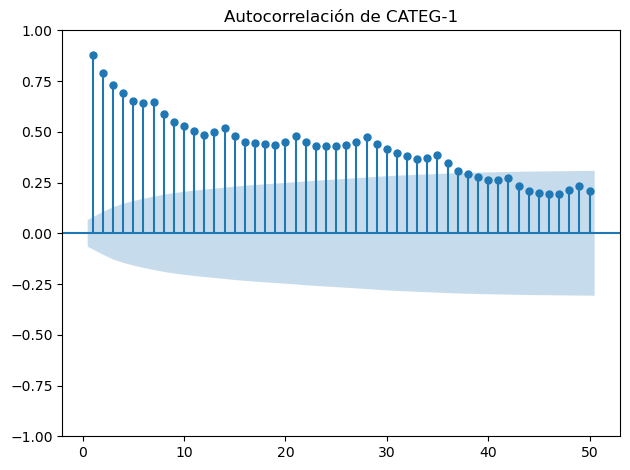

<Figure size 1000x400 with 0 Axes>

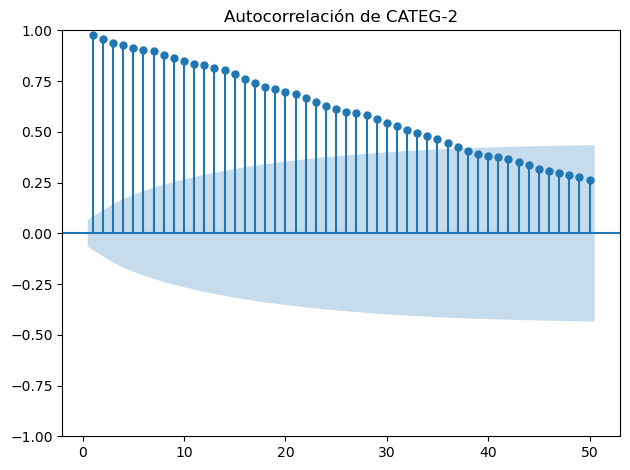

<Figure size 1000x400 with 0 Axes>

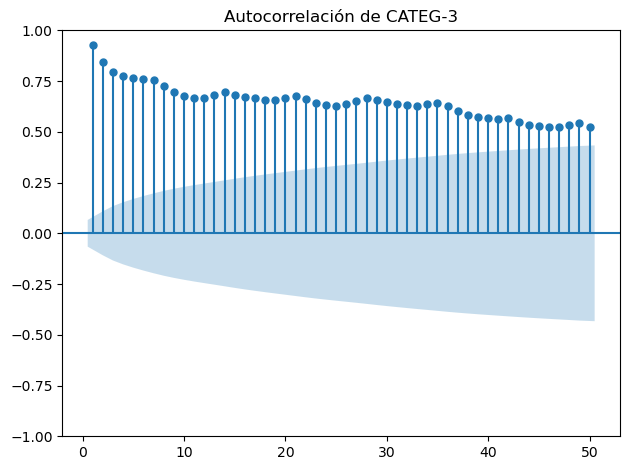

In [220]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

for cat in df["ID"].unique():
    series = df[df["ID"] == cat].sort_values("ds")["y"]
    
    plt.figure(figsize=(10, 4))
    plot_acf(series, lags=50, title=f"Autocorrelación de {cat}", zero=False)
    plt.tight_layout()
    plt.show()

#### El análisis del gráfico nos muestra que al menos en las series de la categorías 1 y 2, la autocorrelación presenta un patrón semanal, es decir que cada 7 días se pueden observar picos en la autocorrelación. Por lo tanto definiremos que el modelo utilice el valor 7 para el parámetro lags.

#### Teniendo en cuenta que el objetivo es predecir las ventas de los próximos 21 días, vamos a entrenar el modelo con los datos de los primeros dos años para poder capturar bien los componentes estacionales, reservaremos los últimos 28 días (21 a estimar + 7 por el lag que agregamos al modelo) para verificar al final que tan bien funciona el modelo que hemos elegido, y los datos intermedios los usaremos como validación para seleccionar el mejor modelo.

In [165]:
#Definimos fechas de inicio y final de cada dataset (train, val y test)
train_start = pd.to_datetime("2019-06-11")
train_end = pd.to_datetime("2021-06-11")
val_start = pd.to_datetime("2021-06-12")
val_end = pd.to_datetime("2021-10-15")
test_start = pd.to_datetime("2021-10-16")
test_end = pd.to_datetime("2021-11-12")

#Separar el dataset
df_train = df[(df["ds"] >= train_start) & (df["ds"] <= train_end)]
df_val = df[(df["ds"] >= val_start) & (df["ds"] <= val_end)]
df_test = df[(df["ds"] >= test_start) & (df["ds"] <= test_end)]

# Tamaños de cada dataset
print(f"Tamaño Training: {df_train.shape[0]}")
print(f"Tamaño Validación: {df_val.shape[0]}")
print(f"Tamaño Test: {df_test.shape[0]}")

Tamaño Training: 2188
Tamaño Validación: 378
Tamaño Test: 84


## <u>Generación del modelo de estimación </u>

#### Vamos a crear varios modelos de NeuralProphet para analizar cuál estima mejor los valores de las ventas diarias. Usaremos un modelo que asuma que la tendencia y la estacionalidad son distintas para cada categoría. Para eso definimo las variables trend_global_local y season_global_local como "local". 

#### Definimos el modelo NeuralProphet con un número de lags=7, basados en el análisis anterior. Para encontrar los mejores parámetros vamos a iterar sobre las posibles combinaciones y nos vamos a quedar con aquella que tenga el menos error medio absoluto promedio para las tres categorías. Los parámetros sobre los que vamos a iterar son la tasa de aprendizaje del modelo (learning_rate), los órdenes de las series de fourier para cada estacionalidad (fourier_order), estos parámetros ajustan que tan variable será la estacionalidad, y por último la cantidad de muestras que se pasaran a lo largo de la red neuronal en cada iteración (batch_size). A cada uno de estos modelos le agregaremos los feriados de Argentina para sumarle información al modelo.

In [29]:
import pandas as pd
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_absolute_error

best_model = None
best_params = None
best_mae = float("inf")

param_pairs = [
    (3,3),
    (3,5),
    (5,3),
    (5,5),
    (7,7),
    (5,7),
    (7,5)
]


def mape(y_true, y_pred):
    return (np.abs((y_true - y_pred) / y_true)).mean() * 100



for lr in [0.2,0.1,0.01, 0.005]:
    for f1,f2 in param_pairs:
            for batch_s in [5,10,20,50]:
                #Definimos el modelo
                model = NeuralProphet(
                    trend_global_local="local",
                    season_global_local="local",
                    yearly_seasonality=False,
                    weekly_seasonality=False,
                    daily_seasonality=False, 
                    learning_rate=lr,
                    n_lags=7,
                    epochs=50,
                    batch_size=batch_s
        
                )
                #Agregamos estacionalidad semanal y anual manualmente para asi poder ajustar el orden de fourier de cada una
                model.add_seasonality(name='Weekly', period=7, fourier_order=f1)
                model.add_seasonality(name='Yearly', period=365.25, fourier_order=f2)
                #Añadimos los feriados nacionales
                model = model.add_country_holidays("AR")

                #Entrenamos el modelo
                metrics = model.fit(df_train,validation_df=df_val, freq="D", progress=False)        
        
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    #Comprobamos que tan bien el modelo se comporta con el dataset de validacion
                    future = model.make_future_dataframe(df_val, n_historic_predictions=True)
                    forecast = model.predict(future)
                
                    #Computamos el error medio absoluto para cada categoria
                    mae_per_category = (
                    forecast
                    .dropna(subset=["y", "yhat1"])
                    .groupby("ID")
                    .apply(lambda g: mean_absolute_error(g["y"], g["yhat1"]))
                    )
    
                    #Computamos el error medio absoluto porcentual (EMAP) para cada categoria
                    mape_per_category = (
                        forecast
                        .dropna(subset=["y", "yhat1"])
                        .loc[lambda df: df["y"] != 0] 
                        .groupby("ID")
                        .apply(lambda g: mape(g["y"], g["yhat1"]))
                    )
                    print(lr,f1,f2,batch_s)
    
                
                print(mape_per_category)
                mean=mape_per_category.mean()
                print(mae_per_category)
                #Si en promedio el EMAP para las tres categorias es el mejor hasta el momento, guardamos ese modelo y parametros
                if mean < best_mae:
                    best_mae = mean
                    best_model = model
                    best_params = {"learning_rate": lr,"f1":f1, "f2":f2,"batch_size":batch_s}

print("Best MAE:", best_mae)
print("Best Parameters:", best_params)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.586% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 8 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 8 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 8 NaN values in column y were auto-imputed.
INFO - (NP.df_utils._infer_frequency) - Major fre

0.2 3 3 5
ID
CATEG-1    13.980595
CATEG-2    28.096235
CATEG-3     7.208556
dtype: float64
ID
CATEG-1      6.354173
CATEG-2      7.308885
CATEG-3    159.744668
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 3 3 10
ID
CATEG-1    11.937868
CATEG-2    29.875716
CATEG-3     7.764512
dtype: float64
ID
CATEG-1      5.388523
CATEG-2      7.791232
CATEG-3    171.038446
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 3 3 20
ID
CATEG-1    12.723815
CATEG-2    38.172499
CATEG-3     7.582945
dtype: float64
ID
CATEG-1      5.852129
CATEG-2      9.573734
CATEG-3    167.231367
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 3 3 50
ID
CATEG-1    12.543359
CATEG-2    36.797860
CATEG-3     7.220544
dtype: float64
ID
CATEG-1      5.797312
CATEG-2      9.197168
CATEG-3    158.987260
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 3 5 5
ID
CATEG-1    11.382620
CATEG-2    19.978638
CATEG-3     7.682491
dtype: float64
ID
CATEG-1      5.190800
CATEG-2      5.714996
CATEG-3    164.711619
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 3 5 10
ID
CATEG-1    11.457523
CATEG-2    24.270997
CATEG-3     7.128619
dtype: float64
ID
CATEG-1      5.280810
CATEG-2      6.895454
CATEG-3    158.161828
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 3 5 20
ID
CATEG-1    14.535333
CATEG-2    32.221145
CATEG-3     9.998913
dtype: float64
ID
CATEG-1      6.777045
CATEG-2      8.429420
CATEG-3    219.493177
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 3 5 50
ID
CATEG-1    12.113818
CATEG-2    47.330352
CATEG-3     7.457464
dtype: float64
ID
CATEG-1      5.582850
CATEG-2     11.840714
CATEG-3    164.795668
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 5 3 5
ID
CATEG-1    11.489809
CATEG-2    24.190903
CATEG-3     7.702729
dtype: float64
ID
CATEG-1      5.225768
CATEG-2      6.638237
CATEG-3    168.243046
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 5 3 10
ID
CATEG-1    12.441066
CATEG-2    33.049152
CATEG-3     8.454157
dtype: float64
ID
CATEG-1      5.753907
CATEG-2      8.510930
CATEG-3    184.063240
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 5 3 20
ID
CATEG-1    14.610482
CATEG-2    26.209217
CATEG-3     7.758099
dtype: float64
ID
CATEG-1      6.743078
CATEG-2      6.918498
CATEG-3    171.180316
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 5 3 50
ID
CATEG-1    11.592377
CATEG-2    37.595007
CATEG-3     7.876527
dtype: float64
ID
CATEG-1      5.320291
CATEG-2      9.446398
CATEG-3    172.907208
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 5 5 5
ID
CATEG-1    16.008801
CATEG-2    33.267618
CATEG-3     9.345114
dtype: float64
ID
CATEG-1      7.259988
CATEG-2      8.580804
CATEG-3    204.577892
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 5 5 10
ID
CATEG-1    13.475936
CATEG-2    38.146532
CATEG-3     9.314638
dtype: float64
ID
CATEG-1      6.158244
CATEG-2      9.901840
CATEG-3    205.067007
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 5 5 20
ID
CATEG-1    11.953742
CATEG-2    38.925705
CATEG-3     7.838449
dtype: float64
ID
CATEG-1      5.461755
CATEG-2      9.932606
CATEG-3    172.527629
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 5 5 50
ID
CATEG-1    11.804630
CATEG-2    20.712326
CATEG-3     7.230971
dtype: float64
ID
CATEG-1      5.360361
CATEG-2      6.078847
CATEG-3    157.204963
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 7 7 5
ID
CATEG-1    11.810234
CATEG-2    25.211216
CATEG-3     7.836380
dtype: float64
ID
CATEG-1      5.370598
CATEG-2      6.942000
CATEG-3    170.320770
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 7 7 10
ID
CATEG-1    12.757976
CATEG-2    31.391184
CATEG-3     7.386023
dtype: float64
ID
CATEG-1      5.849744
CATEG-2      8.289706
CATEG-3    161.888662
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 7 7 20
ID
CATEG-1    11.640300
CATEG-2    36.812872
CATEG-3     8.959369
dtype: float64
ID
CATEG-1      5.337857
CATEG-2      9.467001
CATEG-3    197.837713
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 7 7 50
ID
CATEG-1    12.555364
CATEG-2    33.608332
CATEG-3     7.501862
dtype: float64
ID
CATEG-1      5.842912
CATEG-2      8.807233
CATEG-3    163.981476
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 5 7 5
ID
CATEG-1    18.163074
CATEG-2    64.339156
CATEG-3    10.019923
dtype: float64
ID
CATEG-1      8.440219
CATEG-2     15.710443
CATEG-3    218.551494
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 5 7 10
ID
CATEG-1    12.895857
CATEG-2    43.498431
CATEG-3     7.518108
dtype: float64
ID
CATEG-1      6.002088
CATEG-2     10.734209
CATEG-3    166.327075
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 5 7 20
ID
CATEG-1    12.670745
CATEG-2    31.967783
CATEG-3     7.160181
dtype: float64
ID
CATEG-1      5.913036
CATEG-2      8.404287
CATEG-3    158.970311
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 5 7 50
ID
CATEG-1    11.444730
CATEG-2    38.934365
CATEG-3     7.809210
dtype: float64
ID
CATEG-1      5.222609
CATEG-2      9.964846
CATEG-3    172.676485
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 7 5 5
ID
CATEG-1    12.879176
CATEG-2    23.624253
CATEG-3     7.319582
dtype: float64
ID
CATEG-1      5.861241
CATEG-2      6.690599
CATEG-3    162.627496
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 7 5 10
ID
CATEG-1    14.920902
CATEG-2    33.413453
CATEG-3     9.649748
dtype: float64
ID
CATEG-1      6.882266
CATEG-2      8.702094
CATEG-3    211.005800
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 7 5 20
ID
CATEG-1    13.938206
CATEG-2    28.065955
CATEG-3     8.597904
dtype: float64
ID
CATEG-1      6.624944
CATEG-2      7.506574
CATEG-3    188.708192
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.2 7 5 50
ID
CATEG-1    12.441061
CATEG-2    33.205581
CATEG-3     9.632330
dtype: float64
ID
CATEG-1      5.774047
CATEG-2      8.717544
CATEG-3    211.566919
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 3 3 5
ID
CATEG-1    12.149636
CATEG-2    28.279108
CATEG-3     7.203522
dtype: float64
ID
CATEG-1      5.538712
CATEG-2      7.441391
CATEG-3    158.779545
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 3 3 10
ID
CATEG-1    11.314982
CATEG-2    30.128278
CATEG-3     7.357701
dtype: float64
ID
CATEG-1      5.187274
CATEG-2      7.938442
CATEG-3    161.231546
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 3 3 20
ID
CATEG-1    12.070365
CATEG-2    37.231534
CATEG-3     7.257120
dtype: float64
ID
CATEG-1      5.567460
CATEG-2      9.478586
CATEG-3    158.993931
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 3 3 50
ID
CATEG-1    11.348092
CATEG-2    24.932886
CATEG-3     7.010565
dtype: float64
ID
CATEG-1      5.081735
CATEG-2      6.807274
CATEG-3    152.891625
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 3 5 5
ID
CATEG-1    12.801146
CATEG-2    30.588433
CATEG-3     8.119806
dtype: float64
ID
CATEG-1      5.897223
CATEG-2      8.382738
CATEG-3    179.042231
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 3 5 10
ID
CATEG-1    12.501237
CATEG-2    29.966633
CATEG-3     7.774854
dtype: float64
ID
CATEG-1      5.781659
CATEG-2      8.123588
CATEG-3    171.563539
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 3 5 20
ID
CATEG-1    11.653315
CATEG-2    42.110619
CATEG-3     7.862690
dtype: float64
ID
CATEG-1      5.321641
CATEG-2     10.557346
CATEG-3    173.946427
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 3 5 50
ID
CATEG-1    11.708137
CATEG-2    25.699675
CATEG-3     6.926779
dtype: float64
ID
CATEG-1      5.221629
CATEG-2      7.019197
CATEG-3    151.033602
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 5 3 5
ID
CATEG-1    12.467982
CATEG-2    34.433684
CATEG-3     7.588404
dtype: float64
ID
CATEG-1      5.709054
CATEG-2      8.649072
CATEG-3    167.016271
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 5 3 10
ID
CATEG-1    12.437665
CATEG-2    35.547100
CATEG-3     8.200237
dtype: float64
ID
CATEG-1      5.744843
CATEG-2      8.911049
CATEG-3    179.018840
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 5 3 20
ID
CATEG-1    11.622794
CATEG-2    35.740276
CATEG-3     7.525348
dtype: float64
ID
CATEG-1      5.245584
CATEG-2      9.033836
CATEG-3    166.262965
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 5 3 50
ID
CATEG-1    11.468924
CATEG-2    29.628460
CATEG-3     6.919970
dtype: float64
ID
CATEG-1      5.150288
CATEG-2      7.782923
CATEG-3    149.657786
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 5 5 5
ID
CATEG-1    11.646927
CATEG-2    26.485637
CATEG-3     9.698478
dtype: float64
ID
CATEG-1      5.348725
CATEG-2      7.304440
CATEG-3    210.888915
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 5 5 10
ID
CATEG-1    11.934300
CATEG-2    35.364625
CATEG-3     7.810224
dtype: float64
ID
CATEG-1      5.537945
CATEG-2      9.232457
CATEG-3    171.943203
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 5 5 20
ID
CATEG-1    12.571848
CATEG-2    47.911696
CATEG-3     7.884625
dtype: float64
ID
CATEG-1      5.763376
CATEG-2     12.022247
CATEG-3    173.928986
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 5 5 50
ID
CATEG-1    11.907779
CATEG-2    41.768163
CATEG-3     8.193982
dtype: float64
ID
CATEG-1      5.508966
CATEG-2     10.684153
CATEG-3    181.013108
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 7 7 5
ID
CATEG-1    12.437314
CATEG-2    32.542151
CATEG-3     7.217039
dtype: float64
ID
CATEG-1      5.766431
CATEG-2      8.306025
CATEG-3    160.255704
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 7 7 10
ID
CATEG-1    11.607954
CATEG-2    38.767428
CATEG-3     7.706072
dtype: float64
ID
CATEG-1      5.349184
CATEG-2      9.801007
CATEG-3    170.624037
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 7 7 20
ID
CATEG-1    12.723149
CATEG-2    44.310498
CATEG-3     8.320116
dtype: float64
ID
CATEG-1      5.911429
CATEG-2     11.021800
CATEG-3    183.891583
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 7 7 50
ID
CATEG-1    12.778711
CATEG-2    40.787263
CATEG-3     8.562512
dtype: float64
ID
CATEG-1      5.930770
CATEG-2     10.302897
CATEG-3    189.190100
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 5 7 5
ID
CATEG-1    12.891240
CATEG-2    42.746114
CATEG-3     8.141699
dtype: float64
ID
CATEG-1      5.966904
CATEG-2     10.717844
CATEG-3    179.473812
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 5 7 10
ID
CATEG-1    12.575388
CATEG-2    36.307258
CATEG-3     7.630851
dtype: float64
ID
CATEG-1      5.795645
CATEG-2      9.429308
CATEG-3    168.643480
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 5 7 20
ID
CATEG-1    11.641352
CATEG-2    43.393233
CATEG-3     7.461893
dtype: float64
ID
CATEG-1      5.428653
CATEG-2     11.174103
CATEG-3    165.264145
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 5 7 50
ID
CATEG-1    11.360711
CATEG-2    33.867588
CATEG-3     6.699894
dtype: float64
ID
CATEG-1      5.127285
CATEG-2      8.786120
CATEG-3    146.282530
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 7 5 5
ID
CATEG-1    12.635535
CATEG-2    22.924423
CATEG-3     8.212808
dtype: float64
ID
CATEG-1      5.849047
CATEG-2      6.564571
CATEG-3    181.423123
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 7 5 10
ID
CATEG-1    13.413538
CATEG-2    30.558325
CATEG-3     9.707365
dtype: float64
ID
CATEG-1      6.180830
CATEG-2      8.055614
CATEG-3    211.151657
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 7 5 20
ID
CATEG-1    12.211127
CATEG-2    34.102088
CATEG-3     8.830771
dtype: float64
ID
CATEG-1      5.591296
CATEG-2      8.837472
CATEG-3    194.967017
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.1 7 5 50
ID
CATEG-1    12.246703
CATEG-2    35.468922
CATEG-3     7.856592
dtype: float64
ID
CATEG-1      5.607663
CATEG-2      9.156595
CATEG-3    172.899470
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 3 3 5
ID
CATEG-1    11.687353
CATEG-2    36.507796
CATEG-3     7.085925
dtype: float64
ID
CATEG-1      5.212896
CATEG-2      9.315754
CATEG-3    154.951277
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 3 3 10
ID
CATEG-1    11.787862
CATEG-2    20.864262
CATEG-3     6.958794
dtype: float64
ID
CATEG-1      5.240603
CATEG-2      5.831238
CATEG-3    150.634936
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 3 3 20
ID
CATEG-1    11.558703
CATEG-2    20.260303
CATEG-3     7.648716
dtype: float64
ID
CATEG-1      5.214593
CATEG-2      5.617286
CATEG-3    166.352233
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 3 3 50
ID
CATEG-1    12.382804
CATEG-2    21.215042
CATEG-3     8.212248
dtype: float64
ID
CATEG-1      5.541097
CATEG-2      5.730468
CATEG-3    178.489602
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 3 5 5
ID
CATEG-1    11.934122
CATEG-2    31.187203
CATEG-3     6.892415
dtype: float64
ID
CATEG-1      5.313557
CATEG-2      8.238645
CATEG-3    150.552347
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 3 5 10
ID
CATEG-1    11.965691
CATEG-2    20.696870
CATEG-3     7.339037
dtype: float64
ID
CATEG-1      5.293219
CATEG-2      5.721730
CATEG-3    157.640981
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 3 5 20
ID
CATEG-1    11.561592
CATEG-2    21.026496
CATEG-3     7.037945
dtype: float64
ID
CATEG-1      5.276049
CATEG-2      6.113526
CATEG-3    154.128778
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 3 5 50
ID
CATEG-1    13.471185
CATEG-2    21.910384
CATEG-3     7.779529
dtype: float64
ID
CATEG-1      6.163791
CATEG-2      5.974755
CATEG-3    168.722182
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 5 3 5
ID
CATEG-1    11.659408
CATEG-2    39.035638
CATEG-3     6.960782
dtype: float64
ID
CATEG-1      5.352147
CATEG-2      9.866688
CATEG-3    152.196830
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 5 3 10
ID
CATEG-1    11.614806
CATEG-2    20.310825
CATEG-3     7.085793
dtype: float64
ID
CATEG-1      5.272958
CATEG-2      5.777483
CATEG-3    154.433402
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 5 3 20
ID
CATEG-1    12.323150
CATEG-2    22.264919
CATEG-3     7.264655
dtype: float64
ID
CATEG-1      5.449037
CATEG-2      6.455127
CATEG-3    158.478836
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 5 3 50
ID
CATEG-1    11.591022
CATEG-2    20.777691
CATEG-3     8.656606
dtype: float64
ID
CATEG-1      5.164901
CATEG-2      6.005754
CATEG-3    188.638560
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 5 5 5
ID
CATEG-1    11.632645
CATEG-2    42.321113
CATEG-3     7.027420
dtype: float64
ID
CATEG-1      5.344573
CATEG-2     10.682380
CATEG-3    154.539424
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 5 5 10
ID
CATEG-1    11.609078
CATEG-2    36.382361
CATEG-3     7.052241
dtype: float64
ID
CATEG-1      5.225623
CATEG-2      9.372838
CATEG-3    155.116972
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 5 5 20
ID
CATEG-1    12.422190
CATEG-2    22.208961
CATEG-3     6.869276
dtype: float64
ID
CATEG-1      5.445450
CATEG-2      6.263946
CATEG-3    148.982912
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 5 5 50
ID
CATEG-1    12.508802
CATEG-2    21.295275
CATEG-3     7.776447
dtype: float64
ID
CATEG-1      5.595686
CATEG-2      6.024938
CATEG-3    169.894538
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 7 7 5
ID
CATEG-1    11.756065
CATEG-2    34.414347
CATEG-3     6.849914
dtype: float64
ID
CATEG-1      5.358272
CATEG-2      8.864080
CATEG-3    150.611823
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 7 7 10
ID
CATEG-1    12.194795
CATEG-2    25.515032
CATEG-3     6.911344
dtype: float64
ID
CATEG-1      5.364695
CATEG-2      7.023280
CATEG-3    149.487450
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 7 7 20
ID
CATEG-1    13.350980
CATEG-2    27.482770
CATEG-3     7.374316
dtype: float64
ID
CATEG-1      5.768522
CATEG-2      7.448662
CATEG-3    160.350487
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 7 7 50
ID
CATEG-1    12.574771
CATEG-2    23.246135
CATEG-3     8.476493
dtype: float64
ID
CATEG-1      5.583805
CATEG-2      6.231098
CATEG-3    185.137280
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 5 7 5
ID
CATEG-1    11.474238
CATEG-2    44.391610
CATEG-3     6.982555
dtype: float64
ID
CATEG-1      5.229032
CATEG-2     11.267930
CATEG-3    153.855577
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 5 7 10
ID
CATEG-1    12.164706
CATEG-2    21.829315
CATEG-3     6.945111
dtype: float64
ID
CATEG-1      5.360260
CATEG-2      6.205414
CATEG-3    150.530908
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 5 7 20
ID
CATEG-1    11.657519
CATEG-2    21.111024
CATEG-3     6.920882
dtype: float64
ID
CATEG-1      5.216635
CATEG-2      6.051514
CATEG-3    151.454949
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 5 7 50
ID
CATEG-1    12.760497
CATEG-2    22.263243
CATEG-3     9.265479
dtype: float64
ID
CATEG-1      5.687166
CATEG-2      6.404488
CATEG-3    200.803646
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 7 5 5
ID
CATEG-1    11.743386
CATEG-2    38.766455
CATEG-3     6.997187
dtype: float64
ID
CATEG-1      5.379127
CATEG-2     10.017906
CATEG-3    154.231194
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 7 5 10
ID
CATEG-1    11.730858
CATEG-2    21.289544
CATEG-3     6.857341
dtype: float64
ID
CATEG-1      5.273881
CATEG-2      6.110749
CATEG-3    150.611725
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 7 5 20
ID
CATEG-1    12.293669
CATEG-2    26.703939
CATEG-3     6.874592
dtype: float64
ID
CATEG-1      5.429034
CATEG-2      7.313167
CATEG-3    150.556734
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.01 7 5 50
ID
CATEG-1    12.234496
CATEG-2    19.247168
CATEG-3     7.124672
dtype: float64
ID
CATEG-1      5.682760
CATEG-2      5.475659
CATEG-3    156.851503
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 3 3 5
ID
CATEG-1    11.611930
CATEG-2    25.880346
CATEG-3     6.949290
dtype: float64
ID
CATEG-1      5.208295
CATEG-2      7.009715
CATEG-3    150.865165
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 3 3 10
ID
CATEG-1    11.907307
CATEG-2    18.948778
CATEG-3     7.557238
dtype: float64
ID
CATEG-1      5.429835
CATEG-2      5.532480
CATEG-3    165.163595
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 3 3 20
ID
CATEG-1    12.945875
CATEG-2    22.923117
CATEG-3     8.994407
dtype: float64
ID
CATEG-1      5.817481
CATEG-2      6.427034
CATEG-3    195.568162
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 3 3 50
ID
CATEG-1    12.010553
CATEG-2    23.702204
CATEG-3     8.445276
dtype: float64
ID
CATEG-1      5.414286
CATEG-2      6.722281
CATEG-3    184.388951
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 3 5 5
ID
CATEG-1    12.119237
CATEG-2    24.158713
CATEG-3     6.873489
dtype: float64
ID
CATEG-1      5.361432
CATEG-2      6.755408
CATEG-3    149.258128
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 3 5 10
ID
CATEG-1    12.144795
CATEG-2    21.535461
CATEG-3     7.261006
dtype: float64
ID
CATEG-1      5.456362
CATEG-2      6.177110
CATEG-3    157.337843
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 3 5 20
ID
CATEG-1    11.867108
CATEG-2    21.009046
CATEG-3     7.123949
dtype: float64
ID
CATEG-1      5.436102
CATEG-2      6.160510
CATEG-3    154.229349
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 3 5 50
ID
CATEG-1    12.611283
CATEG-2    23.832451
CATEG-3     8.223194
dtype: float64
ID
CATEG-1      5.598934
CATEG-2      7.146804
CATEG-3    176.913411
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 5 3 5
ID
CATEG-1    12.047405
CATEG-2    22.245275
CATEG-3     6.901499
dtype: float64
ID
CATEG-1      5.319343
CATEG-2      6.171886
CATEG-3    149.644685
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 5 3 10
ID
CATEG-1    11.606020
CATEG-2    20.316949
CATEG-3     7.006523
dtype: float64
ID
CATEG-1      5.221761
CATEG-2      5.771856
CATEG-3    152.495915
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 5 3 20
ID
CATEG-1    11.991608
CATEG-2    20.977987
CATEG-3     8.049635
dtype: float64
ID
CATEG-1      5.435455
CATEG-2      6.015063
CATEG-3    172.159612
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 5 3 50
ID
CATEG-1    14.882317
CATEG-2    22.307443
CATEG-3    11.914873
dtype: float64
ID
CATEG-1      6.891311
CATEG-2      6.473055
CATEG-3    252.651315
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 5 5 5
ID
CATEG-1    12.243825
CATEG-2    28.659803
CATEG-3     6.888389
dtype: float64
ID
CATEG-1      5.392704
CATEG-2      7.646960
CATEG-3    150.264702
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 5 5 10
ID
CATEG-1    11.919457
CATEG-2    21.645354
CATEG-3     6.982292
dtype: float64
ID
CATEG-1      5.277769
CATEG-2      6.145363
CATEG-3    150.355350
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 5 5 20
ID
CATEG-1    11.606101
CATEG-2    21.213608
CATEG-3     7.953330
dtype: float64
ID
CATEG-1      5.224434
CATEG-2      5.677069
CATEG-3    170.216793
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 5 5 50
ID
CATEG-1    16.871867
CATEG-2    34.127384
CATEG-3    14.543305
dtype: float64
ID
CATEG-1      7.491054
CATEG-2      9.456422
CATEG-3    312.314822
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 7 7 5
ID
CATEG-1    12.488839
CATEG-2    19.995840
CATEG-3     6.984206
dtype: float64
ID
CATEG-1      5.467138
CATEG-2      5.783730
CATEG-3    150.624013
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 7 7 10
ID
CATEG-1    12.179619
CATEG-2    28.131386
CATEG-3     6.892875
dtype: float64
ID
CATEG-1      5.404517
CATEG-2      7.534745
CATEG-3    149.878008
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 7 7 20
ID
CATEG-1    15.394851
CATEG-2    25.720271
CATEG-3    11.488955
dtype: float64
ID
CATEG-1      6.928553
CATEG-2      7.088164
CATEG-3    249.749262
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 7 7 50
ID
CATEG-1    17.676548
CATEG-2    34.247529
CATEG-3    14.830589
dtype: float64
ID
CATEG-1      8.019143
CATEG-2      9.450462
CATEG-3    313.462056
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 5 7 5
ID
CATEG-1    11.548851
CATEG-2    35.075798
CATEG-3     6.820161
dtype: float64
ID
CATEG-1      5.166037
CATEG-2      9.097584
CATEG-3    149.229842
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 5 7 10
ID
CATEG-1    11.970432
CATEG-2    20.580896
CATEG-3     7.607122
dtype: float64
ID
CATEG-1      5.414205
CATEG-2      6.228662
CATEG-3    165.078665
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 5 7 20
ID
CATEG-1    12.355150
CATEG-2    19.477428
CATEG-3     6.953119
dtype: float64
ID
CATEG-1      5.432652
CATEG-2      5.553124
CATEG-3    151.221511
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 5 7 50
ID
CATEG-1    15.226800
CATEG-2    32.978990
CATEG-3     9.774565
dtype: float64
ID
CATEG-1      6.836544
CATEG-2      8.913414
CATEG-3    209.927682
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 7 5 5
ID
CATEG-1    12.679604
CATEG-2    20.638654
CATEG-3     6.981976
dtype: float64
ID
CATEG-1      5.545513
CATEG-2      5.877941
CATEG-3    150.463497
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 7 5 10
ID
CATEG-1    11.857592
CATEG-2    20.995852
CATEG-3     6.873296
dtype: float64
ID
CATEG-1      5.301667
CATEG-2      5.853063
CATEG-3    150.663416
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 7 5 20
ID
CATEG-1    15.149288
CATEG-2    25.187457
CATEG-3     8.591438
dtype: float64
ID
CATEG-1      6.788732
CATEG-2      6.950317
CATEG-3    186.219464
dtype: float64


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.213%

0.005 7 5 50
ID
CATEG-1    15.229663
CATEG-2    28.395459
CATEG-3    11.320192
dtype: float64
ID
CATEG-1      6.776958
CATEG-2      8.318185
CATEG-3    242.173844
dtype: float64
Best MAE: 12.804440840822748
Best Parameters: {'learning_rate': 0.005, 'f1': 3, 'f2': 3, 'batch_size': 10}


#### Vemos que el mejor modelo basado en el error medio absoluto (un error promedio de 12% para las tres categorías) es el que tiene por parametros {'learning_rate': 0.005, 'f1': 3, 'f2': 3, 'batch_size': 10}. Procedemos a estimar las ventas para cada categoría en los próximos 21 dias usando el dataset de test

In [173]:
future = best_model.make_future_dataframe(df_test, n_historic_predictions=True)
forecast = best_model.predict(future)


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.429% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.429% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.429% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.552% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.552% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.552%

## <u>Precisión de las estimaciones</u>

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


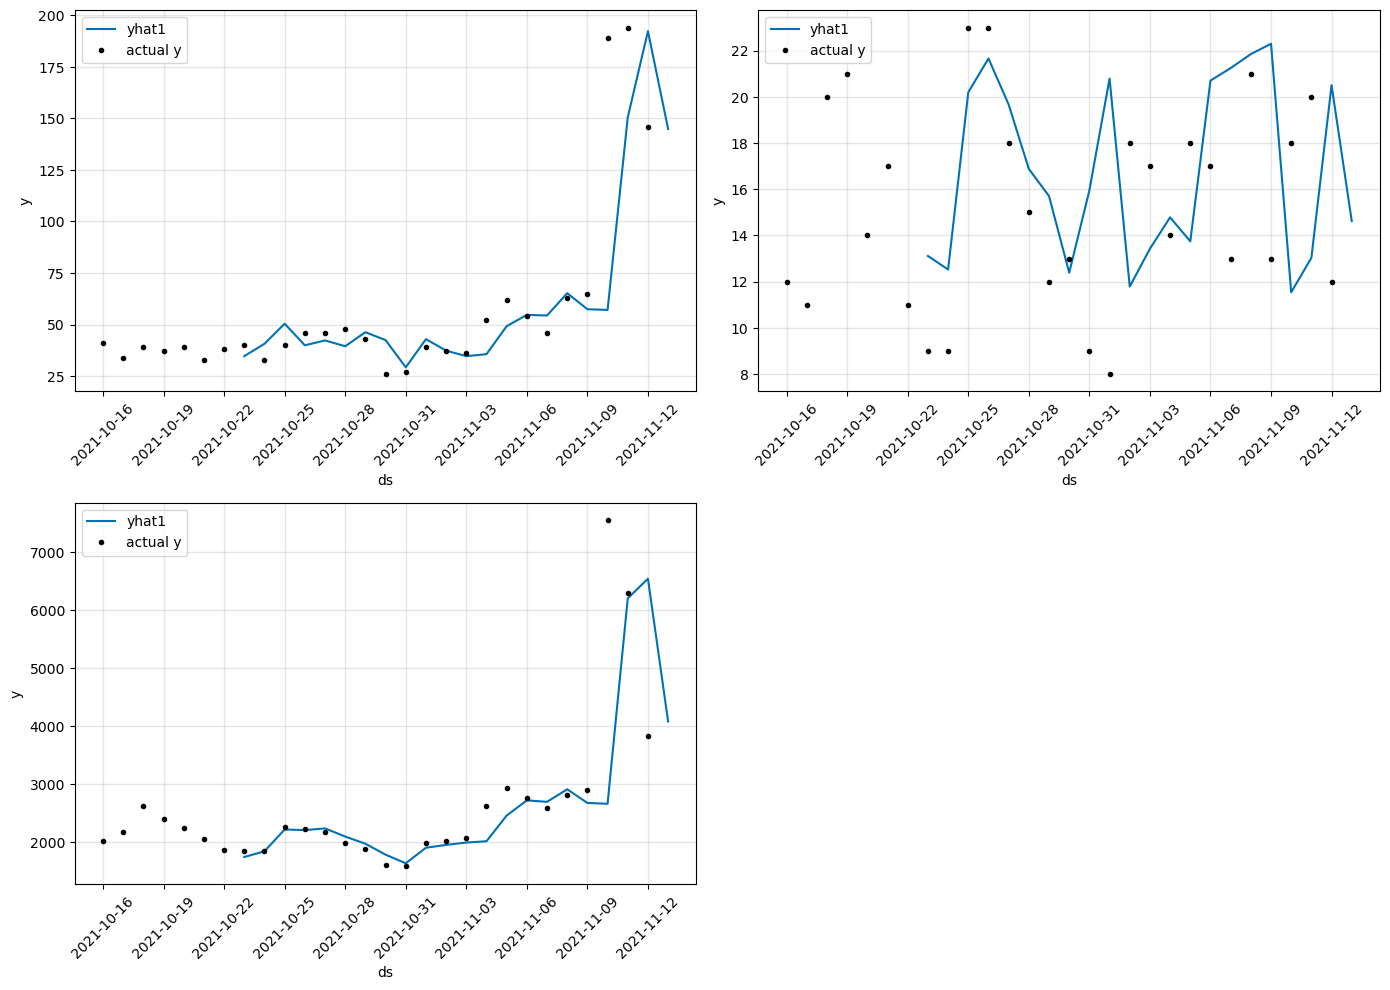

In [184]:
best_model.set_plotting_backend("matplotlib")
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0, 0])
best_model.plot(forecast[forecast["ID"] == "CATEG-1"], ax=ax1)
ax1.tick_params(axis='x', rotation=45)
ax2 = fig.add_subplot(gs[0, 1])
best_model.plot(forecast[forecast["ID"] == "CATEG-2"], ax=ax2)
ax2.tick_params(axis='x', rotation=45)
ax3 = fig.add_subplot(gs[1, 0])
best_model.plot(forecast[forecast["ID"] == "CATEG-3"], ax=ax3)
ax3.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

#### Se puede ver que las estimaciones parecen ser mejores para las categorias 1 y 3 que para la 2. Esto puede deberse en gran parte al alto coeficiente de variación de la categoría 2 que como vimos al analizar las distribuciones de cada serie es mas del doble de las otras dos series. Para tener un resultado mas detallado de cuán errado esta el modelo en la estimación de cada serie calcularemos el error medio absoluto (EMA) y error medio absoluto porcentual (EMAP). El primero nos dirá cuántas unidades en promedio el modelo difiere del valor real de la serie, y el segundo nos dirá en promedio cuán erradas están las estimaciones porcentualmente respecto a los valores reales, por ejemplo un 10 significa que el error medio absoluto de los valores estimados tiene en promedio un 10% de diferencia con respecto al valor real.

In [75]:
def mape(y_true, y_pred):
    return (np.abs((y_true - y_pred) / y_true)).mean() * 100

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Group by ID and compute MAPE
    mape_per_category = (
        forecast
        .dropna(subset=["y", "yhat1"])
        .loc[lambda df: df["y"] != 0]  # Avoid division by zero
        .groupby("ID")
        .apply(lambda g: mape(g["y"], g["yhat1"]))
    )

print("Error Medio Absoluto Porcentual:" )
print( mape_per_category)

Error Medio Absoluto Porcentual:
ID
CATEG-1    19.335075
CATEG-2    37.354350
CATEG-3    11.508164
dtype: float64


In [77]:
from sklearn.metrics import mean_absolute_error

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Group by category and compute MAE
    mae_per_category = (
        forecast
        .dropna(subset=["y", "yhat1"])
        .groupby("ID")
        .apply(lambda g: mean_absolute_error(g["y"], g["yhat1"]))
    )

print("Error Medio Absoluto:" )
print( mae_per_category)

Error Medio Absoluto:
ID
CATEG-1     16.142487
CATEG-2      4.677889
CATEG-3    483.472493
dtype: float64


#### Efectivamente vemos que el error porcentual para la categoría 2 es mucho más grande que para las otras dos siendo de aproximadamente 37%. La categoría 3 tiene el error de estimación mas bajo (11%) y la categoría 1 un error de 20%.

## <u> Estacionalidad semanal y anual de cada categoría</u>

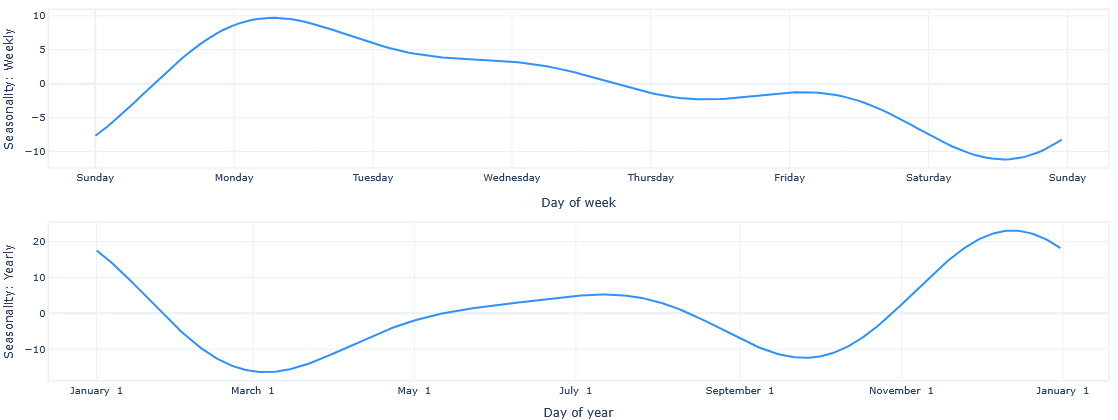

In [126]:
best_model.plot_parameters(df_name="CATEG-1",components=["seasonality"])


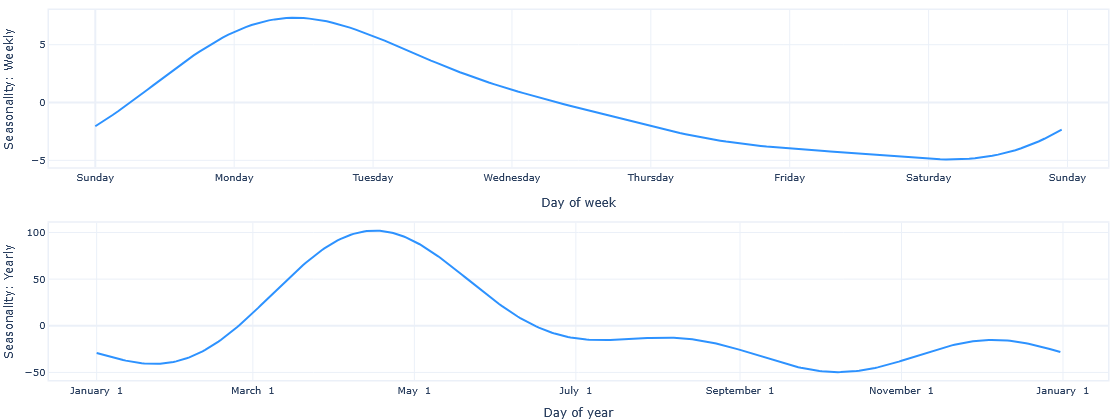

In [128]:
best_model.plot_parameters(df_name="CATEG-2",components=["seasonality"])


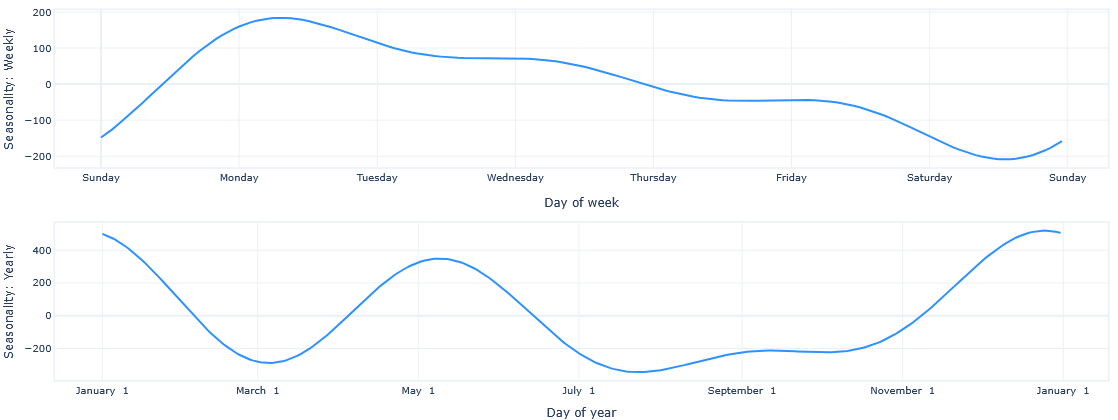

In [130]:
best_model.plot_parameters(df_name="CATEG-3",components=["seasonality"])

#### Vemos que las estacionalidades para cada categoría son distintas, lo que nos indica que es buena decisión haber dejado los parámetros para que cada serie tenga su propia estacionalidad. La categoría 1 y 3 tienen una estacionalidad semanal similar, alta a principio de semana y decae hasta el domingo pero con pequeños repuntes los miercoles y viernes, en cambio la categoría 2 tiene una caída constante a lo largo de la semana. En cuanto a la estacionalidad anual, la categoría 1 tiene un pico alto en finales de año, y un nivel alto constante entre marzo y septiembre, la categoría 2 tiene una fuerte estacionalidad en la primera parte del año, y la categoría 3 tiene dos picos muy marcados en mayo y diciembre.

## <u> Futuras mejoras </u>

-  Generación de un modelo aparte para la categoría dos que incluya estacionalidades más variables (ordenes de fourier mayores podrían ayudar).
-  Inclusión de fechas especificas de ofertas para mejorar las estimaciones de estacionalidad.
-  Uso de otros modelos de estimación como DeepAR y N-BEATS.
-  Análisis de los detalles de los productos de cada categoría para ver si se podrían agregar variables exógenas explicativas.
